## This notebook imports functions to trim/fade samples, then to plot them as waveforms(time), spectrums, and spectrograms. The batch processing section handles multiple files, plot types, and folders.
---------------------------------------------------------------

### Imports



In [1]:
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import os
from scipy import signal
from datetime import datetime
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages
from audioUtilityFunctions import trim, apply_hann_window_fades
from plottingFunctions import plot_time, plot_csd, plot_spectrogram, plot_spectrogram_subtraction, plot_spectrum, plot_spectrogram_subtraction_onesided

### Constants / Config

In [2]:
TRIM_DURATION_SECONDS = 0.5 # duration to trim each sample to before processing
FADE_DURATION_SECONDS = 0.03  # 30ms fade to be added before processing, after trim.
SAMPLE_RATE = 22050 # samples will be resampled to this on load
N_FFT_MS = 200
HOP_LENGTH_MS = 1

PLOT_HEIGHT = 4  # Height in inches for each plot
PLOT_WIDTH = 12  # Width in inches for all plots
SUBPLOT_SPACING = 0.4

### Single file run (with example.wav)




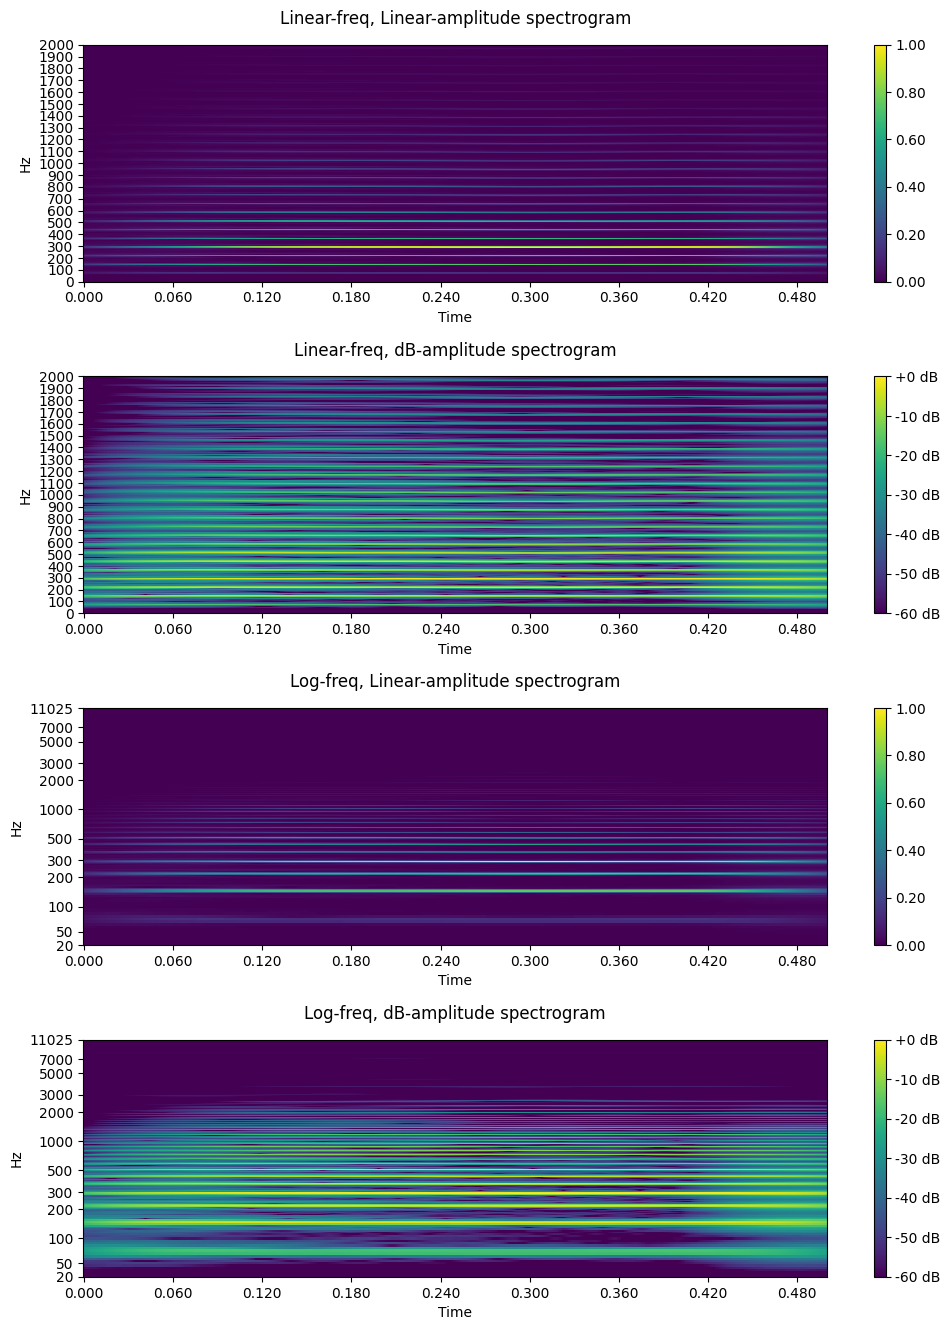

In [4]:
file = 'example.wav'
y, sr = librosa.load(file,sr=22050)
title = os.path.basename(file) 

y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS) 
# Create fig and ax objects
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

plot_spectrogram(y, sr, fig, ax1, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, amplitude='linear', vmin=0, vmax=1, y_scale='linear')
plot_spectrogram(y, sr, fig, ax2, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, amplitude='db', vmin=-60, vmax=0, y_scale='linear')
plot_spectrogram(y, sr, fig, ax3, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, amplitude='linear', vmin=0, vmax=1, y_scale='log')
plot_spectrogram(y, sr, fig, ax4, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, amplitude='db', vmin=-60, vmax=0, y_scale='log')


# plot_spectrum(y, sr, fig, ax3, title=title)
# plot_time(y, sr, fig, ax4, title=title)


plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)


plt.show()
Audio(y, rate=sr)

### Batch processing




##### PDF Option 1: All plot types per audio file in folder

In [27]:


INPUT_FOLDER = './samples/singlenotes/york/sm57/'
OUTPUT_PATH = './PDFs/york/york_notes_sm57.pdf'

# Create output directory if it doesn't exist
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

with PdfPages(OUTPUT_PATH) as pdf:

    # Process all wav files in folder alphabetically
    wav_files = sorted(Path(INPUT_FOLDER).glob('*.wav'))
    for file in wav_files:
        # Load audio
        y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
        title = os.path.basename(file)
        y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
        
        # Create a figure with six subplots
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(PLOT_WIDTH, PLOT_HEIGHT * 6))
        
        # Create plots in subplots
        plot_spectrogram(y, sr, fig, ax1, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=0, vmax=1, y_scale='linear', amplitude='linear', title=title)
        plot_spectrogram(y, sr, fig, ax2, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='linear', amplitude='db', title=title)
        plot_spectrogram(y, sr, fig, ax3, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=0, vmax=1, y_scale='log', amplitude='linear', title=title)
        plot_spectrogram(y, sr, fig, ax4, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='log', amplitude='db', title=title)
        plot_spectrum(y, sr, fig, ax5, title=title)
        plot_time(y, sr, fig, ax6, title=title)
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 2: Same plot type across multiple files


In [26]:

# Configuration
# Available plot types:
# SPECTROGRAM
# SPECTRUM
# TIME

PLOT_TYPE = 'SPECTROGRAM'
INPUT_FOLDER = './samples/singlenotes/york/sm57/'
OUTPUT_PATH = f'./PDFs/York/Notes/{PLOT_TYPE}_sm57.pdf'
ROWS = 2
COLUMNS = 1
PLOTS_PER_PAGE = ROWS * COLUMNS

# Create output directory if it doesn't exist
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)


with PdfPages(OUTPUT_PATH) as pdf:
    # Create specs page
    
    # Create initial figure
    fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(PLOT_WIDTH, PLOT_HEIGHT * ROWS))
    axes = [axes] if ROWS * COLUMNS == 1 else axes.flatten()
    plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)
    plot_count = 0

    for file in sorted(Path(INPUT_FOLDER).glob('*.wav')):
        # Load audio
        y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
        y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
        title = os.path.basename(file)
        
        # Make plot based on type
        if PLOT_TYPE == 'SPECTROGRAM':
            plot_spectrogram(y, sr, fig, axes[plot_count], n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='log', amplitude='db', title=title)
        elif PLOT_TYPE == 'SPECTRUM':
            plot_spectrum(y, sr, fig, axes[plot_count], title=title)
        elif PLOT_TYPE == 'TIME':
            plot_time(y, sr, fig, axes[plot_count], title=title)
        
        plot_count += 1
        
        if plot_count == PLOTS_PER_PAGE:
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)
            fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(PLOT_WIDTH, PLOT_HEIGHT * ROWS))
            axes = [axes] if ROWS * COLUMNS == 1 else axes.flatten()
            plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)
            plot_count = 0
    
    if plot_count > 0:
        # Hide empty subplots
        for i in range(plot_count, PLOTS_PER_PAGE):
            axes[i].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 3: Compare files across folders with same plot type


In [33]:
# Configuration
# Available plot types:
# SPECTROGRAM
# SPECTRUM
# TIME
PLOT_TYPE = 'SPECTROGRAM'
INPUT_FOLDERS = [
   './samples/singlenotes/yamaha/sm57/',
   './samples/singlenotes/york/sm57/',
   # Add more folders here as needed
]
OUTPUT_PATH = f'./PDFs/SingleNoteComparisons/{PLOT_TYPE.lower()}_linearFreq_linear_amp_comparison.pdf'


# Create output directory and get files from all folders
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)
files = [sorted(list(Path(folder).glob('*.wav'))) for folder in INPUT_FOLDERS]
folder_names = [Path(folder).parts[-1] for folder in INPUT_FOLDERS]

with PdfPages(OUTPUT_PATH) as pdf:

    for i in range(max(len(f) for f in files)):
        fig, axes = plt.subplots(len(INPUT_FOLDERS), 1, 
                           figsize=(PLOT_WIDTH, PLOT_HEIGHT * len(INPUT_FOLDERS)))
        axes = [axes] if len(INPUT_FOLDERS) == 1 else axes  # Handle single folder case
        plt.subplots_adjust(hspace=SUBPLOT_SPACING)
        
        for ax, folder_files, name in zip(axes, files, folder_names):
            if i < len(folder_files):
                y, sr = librosa.load(str(folder_files[i]), sr=SAMPLE_RATE)
                y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
                y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
                title = folder_files[i].name
                
                if PLOT_TYPE == 'SPECTROGRAM':
                    plot_spectrogram(y, sr, fig, ax, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=0, vmax=1, y_scale='linear', amplitude='linear', title=title)
                elif PLOT_TYPE == 'SPECTRUM':
                    plot_spectrum(y, sr, fig, ax, title=title)
                elif PLOT_TYPE == 'TIME':
                    plot_time(y, sr, fig, ax, title=title)
            else:
                ax.text(0.5, 0.5, f'No more files in {name} folder', ha='center', va='center')
                ax.set_title(f"{name} (empty)")
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 4: plot entire Audio_DEMOS scales

In [ ]:
# Configuration
# Available plot types:
# SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP
# SPECTROGRAM-LINEAR-FREQ-DECIBELS
# SPECTROGRAM-LOG-FREQ-LINEAR-AMP
# SPECTROGRAM-LOG-FREQ-DECIBELS
# SPECTRUM
# TIME
PLOT_TYPE = 'SPECTROGRAM-LOG-FREQ-DECIBELS'
INPUT_FOLDERS = ['AUDIO_DEMOS/sm57']
OUTPUT_PATH = f'./PDFs/ScaleComparisons/sm57/{PLOT_TYPE.lower()}_scale_comparison.pdf'

# Map plot types to SPEC_PARAMS keys
PLOT_TYPE_TO_PARAMS = {
    'SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP': 'linear_freq_linear_amp',
    'SPECTROGRAM-LINEAR-FREQ-DECIBELS': 'linear_freq_decibels',
    'SPECTROGRAM-LOG-FREQ-LINEAR-AMP': 'log_freq_linear_amp',
    'SPECTROGRAM-LOG-FREQ-DECIBELS': 'log_freq_decibels'
}

# Create output directory and get files from all folders
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)
files = [sorted(list(Path(folder).glob('*.wav'))) for folder in INPUT_FOLDERS]
folder_names = [Path(folder).parts[-1] for folder in INPUT_FOLDERS]

with PdfPages(OUTPUT_PATH) as pdf:
    #  grid dimensions 
    n_rows = 2
    n_cols = 1
    plots_per_page = n_rows * n_cols
    
    # Calculate how many pages we need
    total_files = len(files[0])  # Assuming we're using files from the first folder
    n_pages = (total_files + plots_per_page - 1) // plots_per_page
    
    for page in range(n_pages):
        # Create figure with subplots grid
        fig, axes = plt.subplots(n_rows, n_cols, 
                                figsize=(PLOT_WIDTH * n_cols, PLOT_HEIGHT * n_rows))
        axes = axes.flatten()  # Convert 2D array of axes to 1D for easier indexing
        plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=0.3)
        
        # Plot spectrograms for this page
        for idx in range(plots_per_page):
            file_idx = page * plots_per_page + idx
            if file_idx < total_files:
                y, sr = librosa.load(str(files[0][file_idx]), sr=SAMPLE_RATE)
                title = files[0][file_idx].name
                
                if PLOT_TYPE in PLOT_TYPE_TO_PARAMS:
                    plot_spectrogram(y, sr, fig, axes[idx], 
                                   **SPEC_PARAMS[PLOT_TYPE_TO_PARAMS[PLOT_TYPE]], 
                                   title=title)
                elif PLOT_TYPE == 'SPECTRUM':
                    plot_spectrum(y, sr, fig, axes[idx], title=title)
                elif PLOT_TYPE == 'TIME':
                    plot_time(y, sr, fig, axes[idx], title=title)
            else:
                # Hide empty subplots
                axes[idx].set_visible(False)
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### Plot Spectrograms & Subtraction of scale files, with note names on x axis 

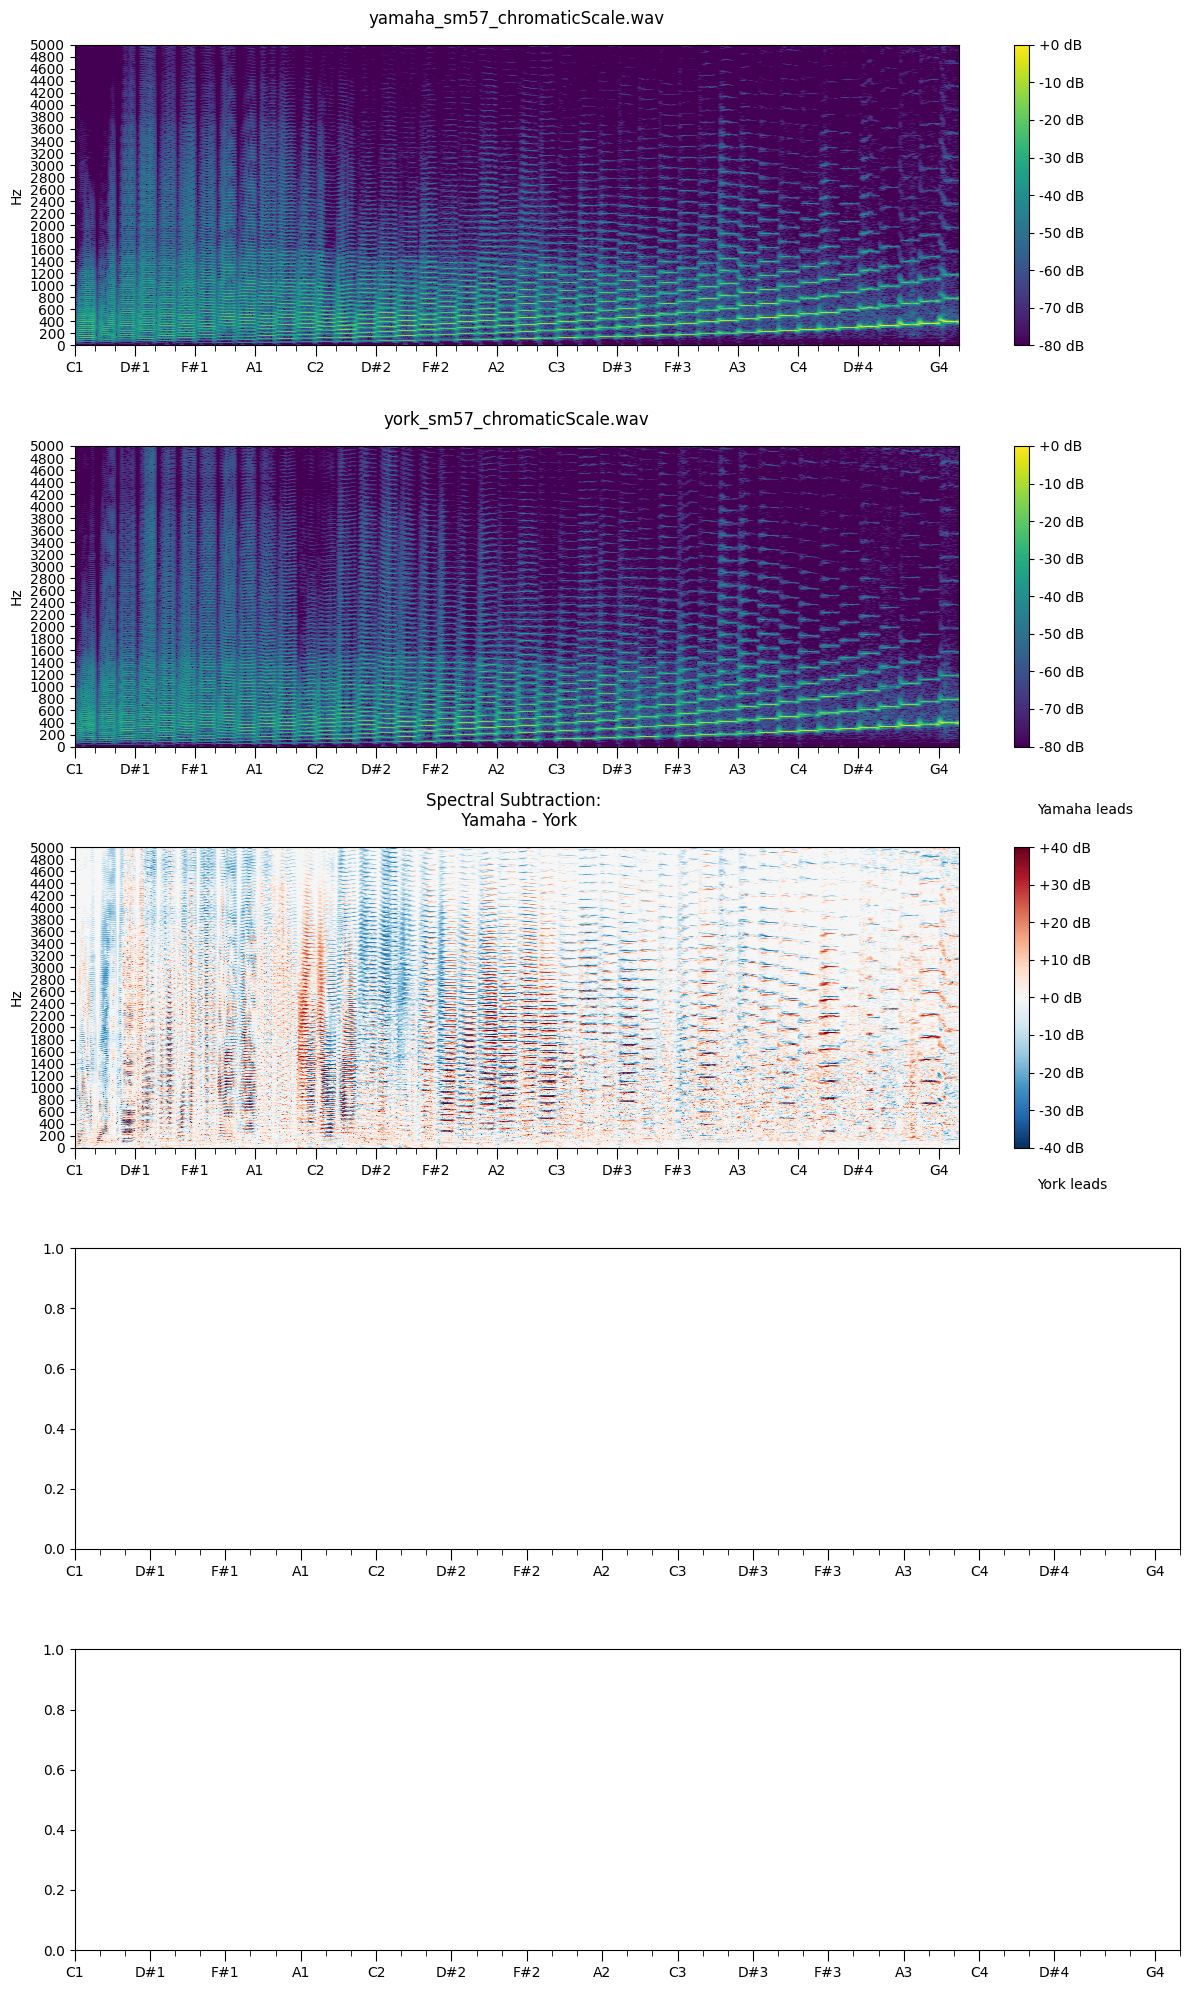

In [ ]:

FILE1 = 'AUDIO_DEMOS/sm57/tuned_scales/yamaha/combinationMethodTuned_yamaha_sm57_chromaticScale.wav'
FILE2 = 'AUDIO_DEMOS/sm57/tuned_scales/york/combinationMethodTuned_york_sm57_chromaticScale.wav'

n_rows = 5
n_cols = 1

# Create figure with subplots grid
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(n_rows, n_cols, figsize=((n_cols * 12), (n_rows * 4)))
plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=0.3)

### load, no need to trim or window these
y1, sr = librosa.load(FILE1, sr=SAMPLE_RATE)
y2, sr = librosa.load(FILE2, sr=SAMPLE_RATE)


plot_spectrogram(y1, sr, fig, ax1, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='log', amplitude='db', title=Path(FILE1).name)
plot_spectrogram(y2, sr, fig, ax2, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='log', amplitude='db', title=Path(FILE2).name)
plot_spectrogram_subtraction(y1, y2, sr, fig, ax3, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-40, vmax=40, y_scale='log', amplitude='db', title1 = 'Yamaha', title2 = 'York')
plot_spectrogram_subtraction_onesided(y1, y2, sr, fig, ax4, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-40, vmax=40, y_scale='log', y1Leads=True, amplitude='db', title1 = 'Yamaha', title2 = 'York')
plot_spectrogram_subtraction_onesided(y1, y2, sr, fig, ax5, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-40, vmax=40, y_scale='log', y1Leads=False, amplitude='db', title1 = 'Yamaha', title2 = 'York')

#########################
#add note ticks on x axis
for ax in [ax1, ax2, ax3, ax4, ax5]:
    
    # Get rid of 'time' label
    ax.set_xlabel('') 
    
    # Get current x-axis limits
    x_min, x_max = ax.get_xlim()
    
    # Calculate positions for 45 points (44 segments)
    x_positions = np.linspace(x_min, x_max, 45)
    
    # Create list of major tick positions and labels - every 3 notes (0,3,6,9,etc)
    major_tick_positions = [x_positions[i] for i in [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 43]]
    major_tick_labels = ['C1', 'D#1', 'F#1', 'A1', 'C2', 'D#2', 'F#2', 'A2', 'C3', 'D#3', 'F#3', 'A3', 'C4', 'D#4', 'G4']
    
    # Set major ticks
    ax.set_xticks(major_tick_positions)
    ax.set_xticklabels(major_tick_labels)
    
    # Set minor ticks at every position
    ax.set_xticks(x_positions, minor=True)
    
    # Optional: adjust minor tick appearance
    ax.tick_params(axis='x', which='major', length=8)
    ax.tick_params(axis='x', which='minor', length=4) # make minor ticks shorter

#########################
# Show them!

plt.tight_layout()
plt. show()

##### make scales audio clips



In [17]:
# Configuration
INPUT_FOLDER = 'combinedTuningMethod500msNormalizedSamples/yamaha'
OUTPUT_PATH = './AUDIO_DEMOS/sm57/tuned_scales/yamaha/combinationMethodTuned_yamaha_sm57_chromaticScale.wav'

# Create output directory
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

# Get all wav files in the input folder
wav_files = sorted(Path(INPUT_FOLDER).glob('*.wav'))

# List to store processed audio segments
processed_segments = []

for file in wav_files[:44]:
    # Load audio file
    y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
    
    # Trim and apply window (starting without the pre-onset period)
    y = trim(y, sr, 0.02, TRIM_DURATION_SECONDS)
    y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
    
    # Append processed segment to list
    processed_segments.append(y)

# Concatenate all processed segments
concatenated_audio = np.concatenate(processed_segments)

# Write concatenated audio to output file using soundfile
sf.write(OUTPUT_PATH, concatenated_audio, SAMPLE_RATE)


print(f"Concatenated audio saved to {OUTPUT_PATH}")

Concatenated audio saved to ./AUDIO_DEMOS/sm57/tuned_scales/yamaha/combinationMethodTuned_yamaha_sm57_chromaticScale.wav


In [12]:
# Configuration
INPUT_FOLDER = './tuned_samples/yamaha/'
OUTPUT_PATH = './AUDIO_DEMOS/sm57/tuned_scales/yamaha/tuned_yamaha_sm57_chromaticScale.wav'

# Create output directory
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

# Get all wav files in the input folder
wav_files = sorted(Path(INPUT_FOLDER).glob('*.wav'))

# List to store processed audio segments
processed_segments = []

for file in wav_files[:44]:
    # Load audio file
    y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
    
    # Trim and apply window (starting without the pre-onset period)
    y = trim(y, sr, 0.02, TRIM_DURATION_SECONDS)
    y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
    
    # Append processed segment to list
    processed_segments.append(y)

# Concatenate all processed segments
concatenated_audio = np.concatenate(processed_segments)

# Write concatenated audio to output file using soundfile
sf.write(OUTPUT_PATH, concatenated_audio, SAMPLE_RATE)


print(f"Concatenated audio saved to {OUTPUT_PATH}")

Concatenated audio saved to ./AUDIO_DEMOS/sm57/tuned_scales/yamaha/tuned_yamaha_sm57_chromaticScale.wav


##### Plot spectrograms and subtractions of individual files (almost same as scales one but with trim and windowing added)

In [ ]:
##### Plot Spectrograms & Subtraction of scale files, with note names on x axis 

FILE1 = 'samples/singlenotes/yamaha/sm57/yamaha_037_C4_sm57.wav'
FILE2 = 'samples/singlenotes/york/sm57/york_037_C4_sm57.wav'

n_rows = 3
n_cols = 1

# Create figure with subplots grid
fig, (ax1, ax2, ax3) = plt.subplots(n_rows, n_cols, figsize=((n_cols * 12), (n_rows * 5)))
plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=0.3)

### load, no need to trim or window these
y1, sr = librosa.load(FILE1, sr=SAMPLE_RATE)
y2, sr = librosa.load(FILE2, sr=SAMPLE_RATE)


y1 = trim(y1, sr, 0, TRIM_DURATION_SECONDS)
y1 = apply_hann_window_fades(y1, sr, FADE_DURATION_SECONDS)

y2 = trim(y2, sr, 0, TRIM_DURATION_SECONDS)
y2 = apply_hann_window_fades(y2, sr, FADE_DURATION_SECONDS)


plot_spectrogram(y1, sr, fig, ax1, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='linear', amplitude='db', title=Path(FILE1).name)
plot_spectrogram(y2, sr, fig, ax2, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='linear', amplitude='db', title=Path(FILE2).name)
plot_spectrogram_subtraction(y1, y2, sr, fig, ax3, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS,  vmin=-40, vmax=40, y_scale='linear', amplitude='db', title1 = 'Yamaha', title2 = 'York')


plt.tight_layout()
plt. show()

### Alignment (needs work)

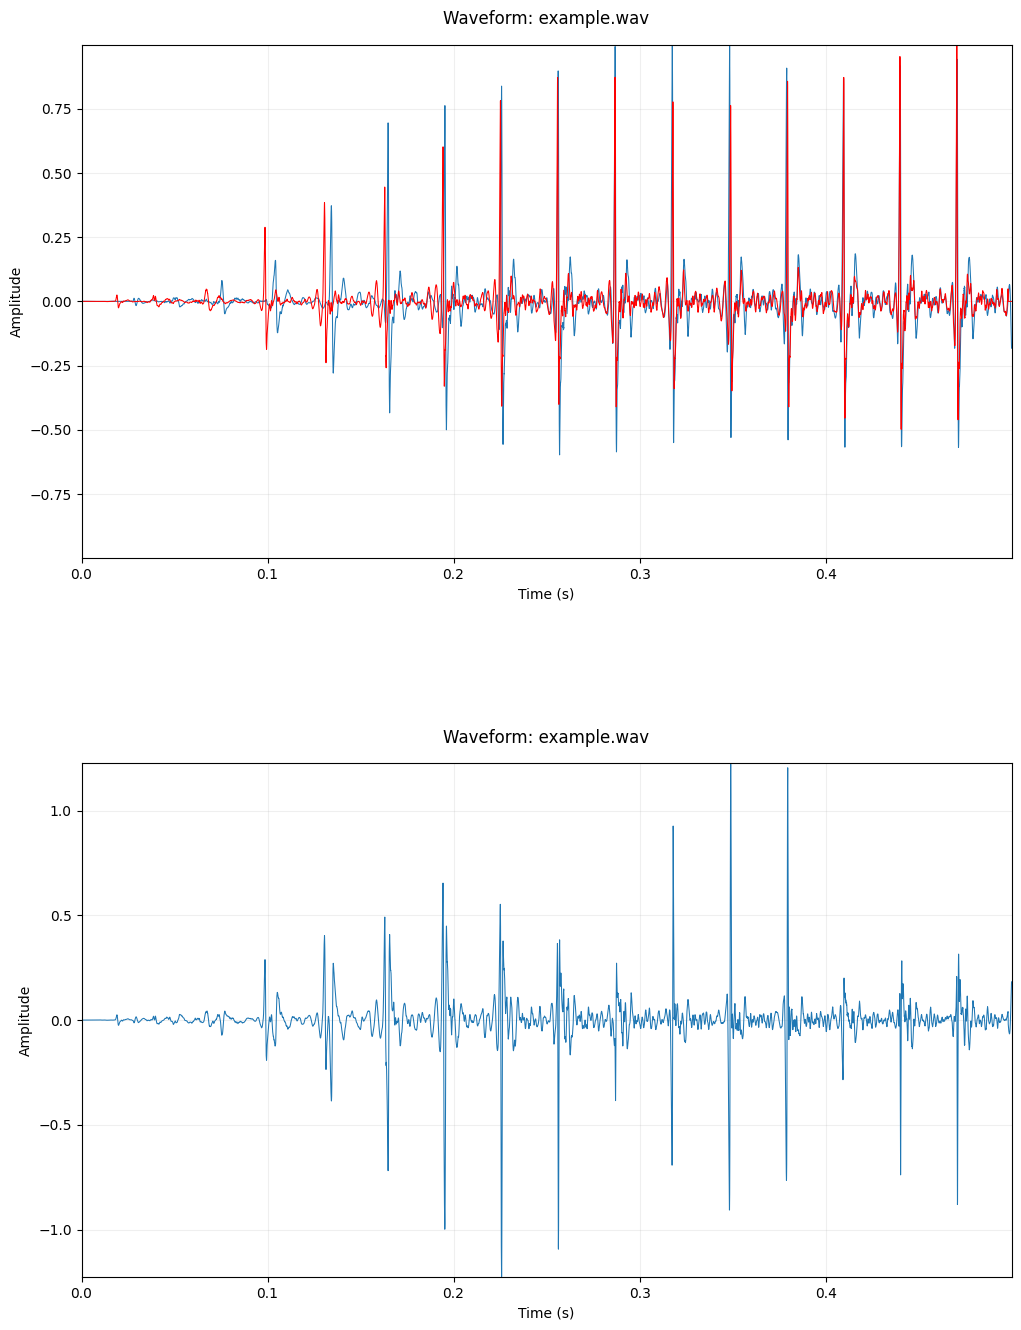

In [6]:
file1 = 'tuned_yam.wav'
file2 = 'tuned_york.wav'
y1, sr = librosa.load(file1,sr=22050)
y2, sr = librosa.load(file2,sr=22050)


def align_signals(y1, y2):
    
 
   # Get correlation only for small window of lags
   # Get correlation and lags
    correlation = signal.correlate(y1, y2, mode="full")
    lags = signal.correlation_lags(y1.size, y2.size, mode="full")

    # Find zero index
    zero_idx = np.where(lags == 0)[0][0]

    # Look at negative lags only (up to zero)
    negative_correlation = correlation[:zero_idx]
    negative_lags = lags[:zero_idx]

    # Find peaks in the negative side with conditions
    peaks, _ = signal.find_peaks(negative_correlation, 
                                height=np.max(correlation) * 0.5,  # Only peaks above 50% of max correlation
                                distance=50,  # Minimum samples between peaks
                                prominence=0.1)  # Minimum prominence of peaks

    if len(peaks) == 0:
        lag = 0
    else:
        # Take the last peak (closest to zero)
        last_peak_idx = peaks[-1]
        lag = negative_lags[last_peak_idx]


    
    # Align with zero padding to keep length
    if lag > 0:
        y2 = np.pad(y2, (lag, 0))[:len(y1)]
    else:
        y2 = np.pad(y2, (0, -lag))[-len(y1):]
    
    return y1, y2

def plot_time(y, sr, fig, ax, color='#1f77b4', title=None):
    """Plot time-domain signal with improved visualization."""
    # Create time axis in seconds
    times = np.arange(len(y)) / sr
    
    # Plot the waveform
    ax.plot(times, y, color, linewidth=0.75)  # Thinner line for better detail
    
    # Set title and labels 
    if title:
        ax.set_title(f"Waveform: {title}", pad=15)    
    else:
        ax.set_title('Waveform', pad=15)    
        
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    
    # Add grid for better readability
    ax.grid(True, alpha=0.2)
    
    # Set y-axis limits symmetrically based on the signal
    max_amp = np.max(np.abs(y))
    ax.set_ylim(-max_amp, max_amp)
    ax.set_xlim(0, times[-1])

    
y1 = trim(y1, sr, 0, 0.5)


y2 = trim(y2, sr, 0, 0.5)

y1, y2 = align_signals(y1, y2)

# Create fig and ax objects
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

plot_time(y1, sr, fig, ax1, title=title)
plot_time(y2, sr, fig, ax1, color='r', title=title)
subtraction = y2 - y1
plot_time(subtraction, sr, fig, ax2, title=title)
plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)


plt.show()
